In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout, SimpleRNN, Input, GRU
from keras.models import Model
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
os.chdir('../')
path = os.getcwd()
print(path)

C:\home\program


In [3]:
tokyo = pd.read_csv('Stock2/東京(2014-1_2020-11).csv')
data =pd.read_csv("Weather/Weather2010---2021-1.csv")

tokyo['日付'] = pd.to_datetime(tokyo['日付'], format='%Y/%m/%d')
data = data.drop(index=data.index[[0, 1, 2]])
tokyo = tokyo.drop_duplicates(['日付', '終値'])

In [4]:
tokyo.set_index('日付')
dateTimeIndex = pd.DatetimeIndex(tokyo['日付'])
tokyo.index = dateTimeIndex
tokyo = tokyo.resample('D').interpolate()
tokyo.drop("日付", axis=1)

,終値
日付,
2014-01-06,686.0
2014-01-07,677.0
2014-01-08,692.0
2014-01-09,681.0
2014-01-10,686.0
...,...
2020-11-16,461.1
2020-11-17,479.4
2020-11-18,468.2


In [5]:
dateTimeIndex = pd.DatetimeIndex(data['Unnamed: 0'])
data.index = dateTimeIndex
data = data.drop('Unnamed: 0', axis=1)
data = data.replace(['--', int(0)],['0.0', int(0)])

In [6]:
tokyo = tokyo.astype({'終値': int})
W_tokyo = data.astype({'降水量(mm)': float})
W_tokyo = W_tokyo.astype({'降水量(mm)': int})

In [7]:
Tokyo = pd.DataFrame(tokyo['終値']['2014-01-01':'2020-11-01'])
N_Tokyo = pd.DataFrame(tokyo['終値']['2014-01-01':'2020-11-01'])
W_Tokyo = pd.DataFrame(W_tokyo[(W_tokyo.index >= dt.datetime(2014,1,1)) & (W_tokyo.index < dt.datetime(2020,11,1))])

In [8]:
Tokyo['Weather(mm)'] = W_tokyo['降水量(mm)']

In [9]:
Tokyo

,終値,Weather(mm)
日付,,
2014-01-06,686,0
2014-01-07,677,0
2014-01-08,692,15
2014-01-09,681,4
2014-01-10,686,0
...,...,...
2020-10-28,411,0
2020-10-29,411,0
2020-10-30,410,0


In [10]:
scale = pd.DataFrame(np.nan_to_num(np.log(Tokyo['終値'].values + 1)))
scale.index = Tokyo.index.values

scale['second'] = np.nan_to_num(np.log(Tokyo['Weather(mm)'].values + 1))
X_day_second = tokyo.index.values

In [11]:
X_orig = np.nan_to_num(np.log(Tokyo['終値'].values + 1))
X_day = Tokyo.index.values

X_orig_second = np.nan_to_num(np.log(Tokyo['Weather(mm)'].values + 1))
X_day_second = Tokyo.index.values

In [12]:
half = round(len(X_orig)/2)

X_train = X_orig[:half-1]
X_test = X_orig[half:]
X_train_day = X_day[:half-1]
X_test_day = X_day[half:]

X_train_second = X_orig_second[:half-1]
X_test_second = X_orig_second[half:]
X_train_day_second = X_day_second[:half-1]
X_test_day_second = X_day_second[half:]

In [13]:
def show_graph(day, data, label, color="b", ylabel='stock price'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()

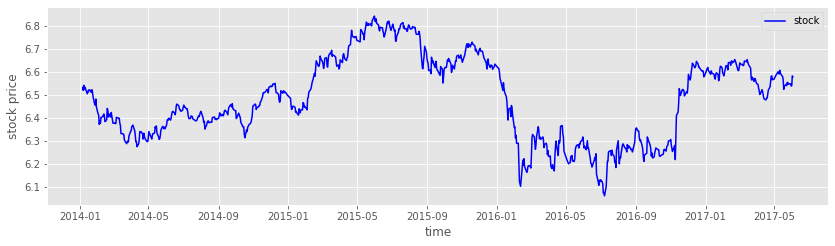

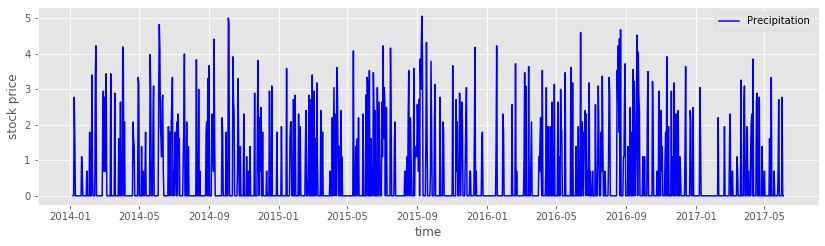

In [14]:
import pylab
plt.style.use('ggplot')
show_graph(X_train_day, X_train, 'stock')
show_graph(X_train_day_second, X_train_second, 'Precipitation')

In [15]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 1245)

In [16]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

In [17]:
def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

In [18]:
def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

In [19]:
time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

(2, 1245)
(1245, 2)
before max 6.532334292222349
Normalize
after max 0.9555422091632877
(2, 1245)


In [20]:
input_dim = x.shape[-1]
timesteps = x.shape[1]

In [21]:
def create_model(input_dim,time_steps,latent_dim,model_option,batch_size=1,optimizer='adam'):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

In [22]:
from copy import copy 

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [23]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='lstm')

(1245, 3, 2)
input_dim: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            59040     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


In [24]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

Epoch 1/100
1245/1245 [==============================] - 1s 518us/step - loss: 0.1949 - mse: 0.1949
Epoch 2/100
1245/1245 [==============================] - 0s 126us/step - loss: 0.0695 - mse: 0.0695
Epoch 3/100
1245/1245 [==============================] - 0s 127us/step - loss: 0.0308 - mse: 0.0308
Epoch 4/100
1245/1245 [==============================] - 0s 122us/step - loss: 0.0131 - mse: 0.0131
Epoch 5/100
1245/1245 [==============================] - 0s 121us/step - loss: 0.0055 - mse: 0.0055
Epoch 6/100
1245/1245 [==============================] - 0s 125us/step - loss: 0.0023 - mse: 0.0023
Epoch 7/100
1245/1245 [==============================] - 0s 133us/step - loss: 8.9617e-04 - mse: 8.9617e-04
Epoch 8/100
1245/1245 [==============================] - 0s 133us/step - loss: 4.5525e-04 - mse: 4.5525e-04
Epoch 9/100
1245/1245 [==============================] - 0s 139us/step - loss: 3.7544e-04 - mse: 3.7544e-04
Epoch 10/100
1245/1245 [==============================] - 0s 133us/step - lo

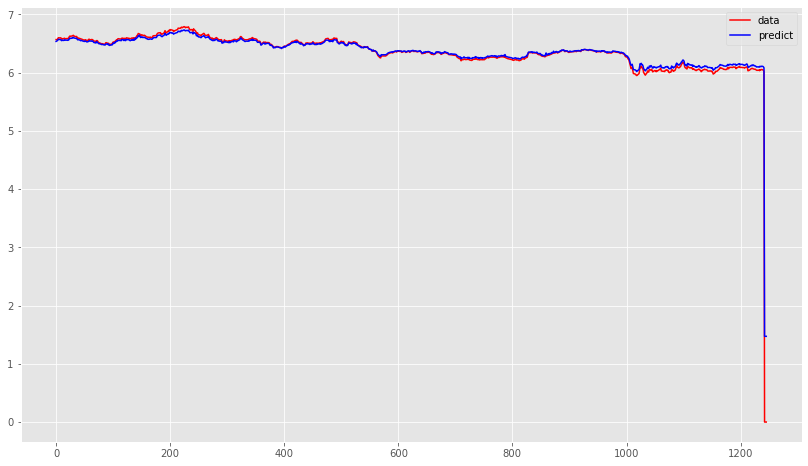

x_scale:  (1246, 3, 2)


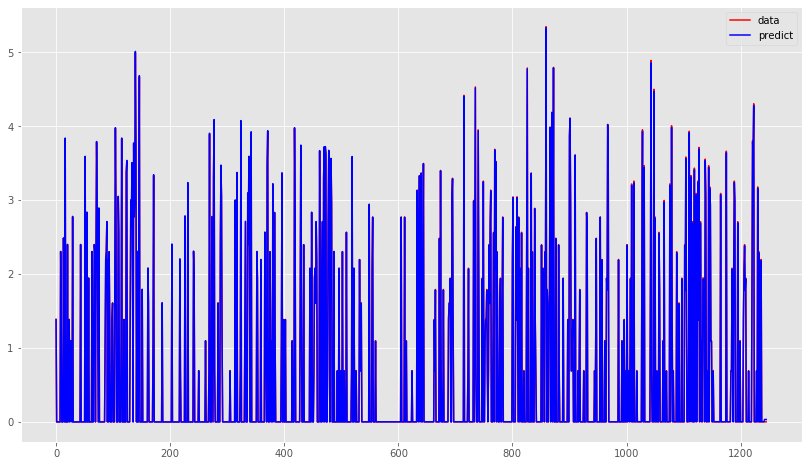

1246/1246 [==============================] - 0s 94us/step
model evaluate mse: [0.19234873483594309, 0.19234871864318848]


In [25]:
from pathlib import Path
from keras.callbacks import TensorBoard

log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=100, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [26]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.05280672588574414
rmse: 0.008218667415173712
0.030512696650458925


In [27]:
lstm_test = np.exp(x_scale_test[:, 0, 0])
lstm_pred = np.exp(predict_test[:, 0, 0])

In [28]:
W_lstm_predict = pd.DataFrame(lstm_pred)
W_lstm_predict.index = X_day_second[half:]

W_lstm_test = pd.DataFrame(lstm_test)
W_lstm_test.index = X_day[half:]

# GRU

In [29]:
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='gru')

input_dim: 2
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 3, 120)            44280     
_________________________________________________________________
dense_2 (Dense)              (None, 3, 2)              242       
Total params: 44,522
Trainable params: 44,522
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1245/1245 [==============================] - 1s 505us/step - loss: 0.1942 - mse: 0.1942
Epoch 2/100
1245/1245 [==============================] - 0s 154us/step - loss: 0.0414 - mse: 0.0414
Epoch 3/100
1245/1245 [==============================] - 0s 141us/step - loss: 0.0134 - mse: 0.0134
Epoch 4/100
1245/1245 [==============================] - 0s 150us/step - loss: 0.0038 - mse: 0.0038
Epoch 5/100
1245/1245 [==============================] - 0s 146us/step - loss: 8.3092e-04 - mse: 8.3092e-04
Epoch 6/100
1245/1245 [==============================] - 0s 153us/step - loss: 4.2952e-04 - mse: 4.2952e-04
Epoch 7/100
1245/1245 [==============================] - 0s 145us/step - loss: 3.6946e-04 - mse: 3.6946e-04
Epoch 8/100
1245/1245 [==============================] - 0s 140us/step - loss: 3.4402e-04 - mse: 3.4402e-04
Epoch 9/100
1245/1245 [==============================] - 0s 142us/step - loss: 3.2941e-04 - mse: 3.2941e-04
Epoch 10/100
1245/1245 [==============================] - 0s

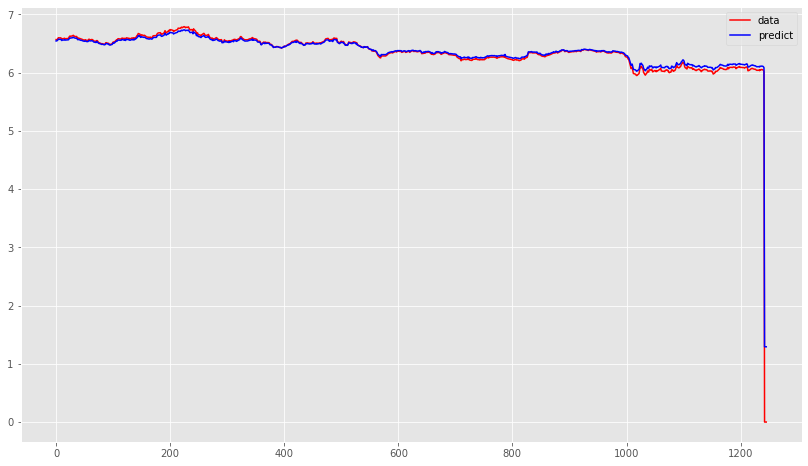

x_scale:  (1246, 3, 2)


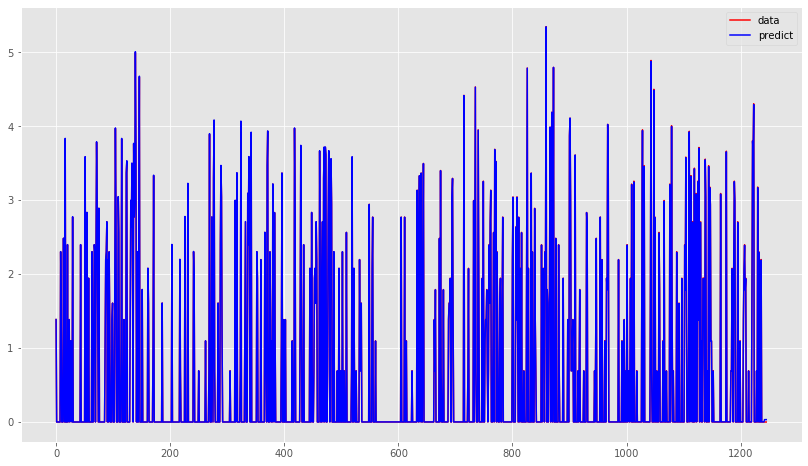

1246/1246 [==============================] - 0s 99us/step
model evaluate mse: [0.17022559549031632, 0.17022565007209778]


In [30]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=100, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [31]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.0470789251506735
rmse: 0.004434257765674065
0.025756591458173782


In [32]:
gru_test = np.exp(x_scale_test[:, 0, 0])
gru_pred = np.exp(predict_test[:, 0, 0])

In [33]:
W_gru_predict = pd.DataFrame(gru_pred)
W_gru_predict.index = X_day_second[half:]

W_gru_test = pd.DataFrame(gru_test)
W_gru_test.index = X_day[half:]

# plot

In [34]:
W_lstm_test = W_lstm_test.drop(W_lstm_test.index[[len(W_lstm_test)-1,len(W_lstm_test)-2, len(W_lstm_test)-3, len(W_lstm_test)-4]])
W_lstm_predict = W_lstm_predict.drop(W_lstm_predict.index[[len(W_lstm_predict)-1,len(W_lstm_predict)-2, len(W_lstm_predict)-3, len(W_lstm_predict)-4]])
W_gru_test = W_gru_test.drop(W_gru_test.index[[len(W_gru_test)-1,len(W_gru_test)-2, len(W_gru_test)-3, len(W_gru_test)-4]])
W_gru_predict = W_gru_predict.drop(W_gru_predict.index[[len(W_gru_predict)-1,len(W_gru_predict)-2, len(W_gru_predict)-3, len(W_gru_predict)-4]])

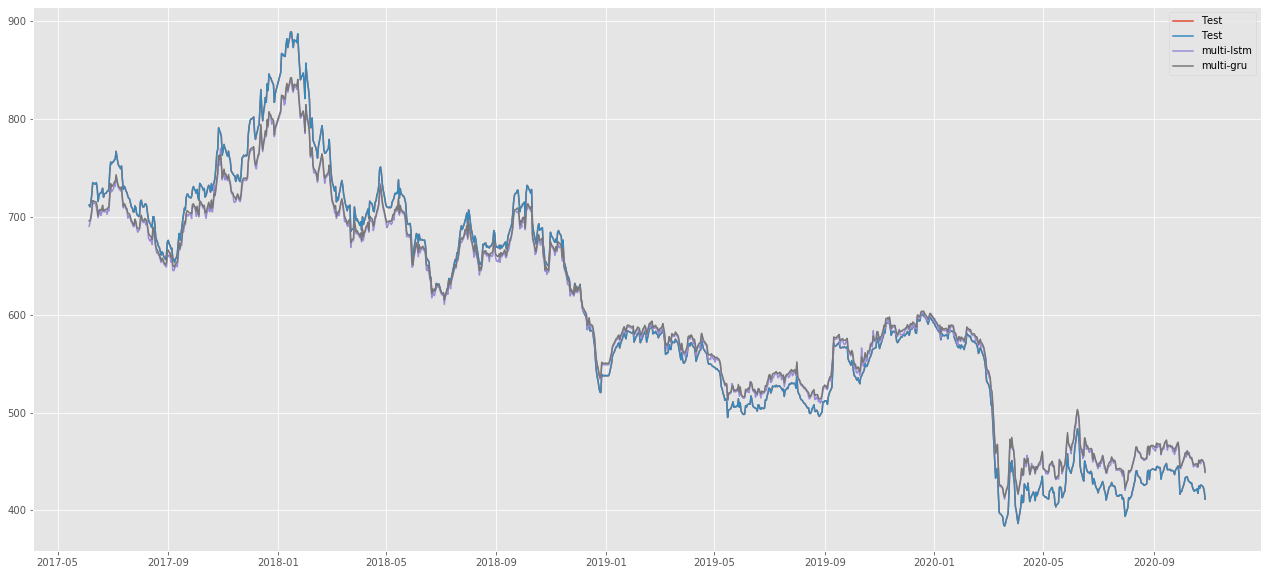

In [35]:
plt.figure(figsize=(22,10))
plt.plot(W_lstm_test, label = 'Test')
plt.plot(W_gru_test, label = 'Test')
plt.plot(W_lstm_predict, label = 'multi-lstm')
plt.plot(W_gru_predict, label = 'multi-gru')
plt.legend(loc='best')
plt.savefig('画像/画像/11-26/Weather-epoch100.png')

# simple

In [36]:
L = len(N_Tokyo)
Y = N_Tokyo  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [37]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [38]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [39]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [40]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [41]:
# train, testデータを定義
X_train = X[:half-1, :, :]
X_test = X[half:, :, :]
Y_train = Y[:half-1, :]
YN_test = Y[half:, :]

# lstm

In [42]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh',batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/100
 - 1s - loss: 0.2453 - mean_absolute_error: 0.4448
Epoch 2/100
 - 0s - loss: 0.1014 - mean_absolute_error: 0.2593
Epoch 3/100
 - 0s - loss: 0.0233 - mean_absolute_error: 0.1254
Epoch 4/100
 - 0s - loss: 0.0153 - mean_absolute_error: 0.1057
Epoch 5/100
 - 0s - loss: 0.0121 - mean_absolute_error: 0.0938
Epoch 6/100
 - 0s - loss: 0.0090 - mean_absolute_error: 0.0805
Epoch 7/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0670
Epoch 8/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0536
Epoch 9/100
 - 0s - loss: 0.0026 - mean_absolute_error: 0.0414
Epoch 10/100
 - 0s - loss: 0.0016 - mean_absolute_error: 0.0310
Epoch 11/100
 - 0s - loss: 9.8730e-04 - mean_absolute_error: 0.0238
Epoch 12/100
 - 0s - loss: 7.2683e-04 - mean_absolute_error: 0.0198
Epoch 13/100
 - 0s - loss: 6.2263e-04 - mean_absolute_error: 0.0182
Epoch 14/100
 - 0s - loss: 5.8462e-04 - mean_absolute_error: 0.0177
Epoch 15/100
 - 0s - loss: 5.6807e-04 - mean_absolute_error: 0.0174
Epoch 16/100
 - 0s - loss: 5.

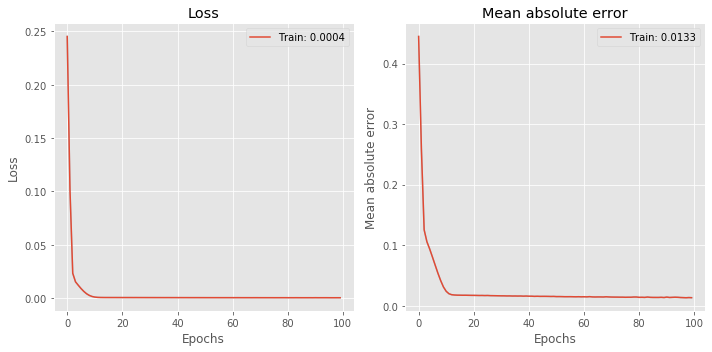

In [43]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=100, verbose=2).history
plot_history(history)
lstm_predict = model.predict(X_test)

# GRU

In [44]:
model = Sequential()
model.add(GRU(10, activation='tanh', batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/100
 - 1s - loss: 0.1370 - mean_absolute_error: 0.3105
Epoch 2/100
 - 0s - loss: 0.0132 - mean_absolute_error: 0.0918
Epoch 3/100
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0737
Epoch 4/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0643
Epoch 5/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0546
Epoch 6/100
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0446
Epoch 7/100
 - 0s - loss: 0.0018 - mean_absolute_error: 0.0351
Epoch 8/100
 - 0s - loss: 0.0011 - mean_absolute_error: 0.0268
Epoch 9/100
 - 0s - loss: 7.2935e-04 - mean_absolute_error: 0.0207
Epoch 10/100
 - 0s - loss: 5.4228e-04 - mean_absolute_error: 0.0171
Epoch 11/100
 - 0s - loss: 4.7518e-04 - mean_absolute_error: 0.0157
Epoch 12/100
 - 0s - loss: 4.5696e-04 - mean_absolute_error: 0.0151
Epoch 13/100
 - 0s - loss: 4.5103e-04 - mean_absolute_error: 0.0149
Epoch 14/100
 - 0s - loss: 4.5054e-04 - mean_absolute_error: 0.0150
Epoch 15/100
 - 0s - loss: 4.5134e-04 - mean_absolute_error: 0.0150
Epoch 16/100
 - 0s - 

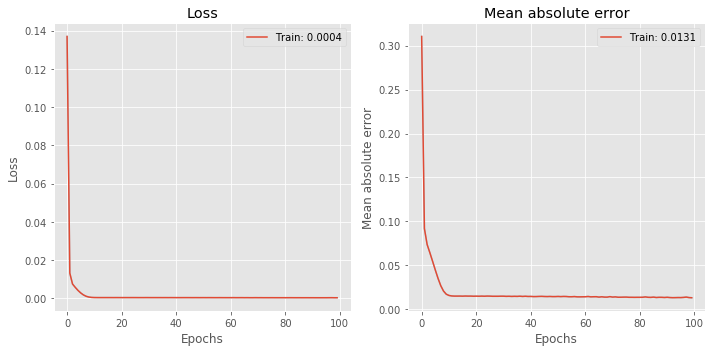

In [45]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=100, verbose=2).history
plot_history(history)
gru_predict = model.predict(X_test)

# rescale

In [46]:
YN_test = scaler1.inverse_transform(YN_test)
YN_test = pd.DataFrame(YN_test)
YN_test.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [47]:
lstm_predict = scaler1.inverse_transform(lstm_predict)
lstm_predict = pd.DataFrame(lstm_predict)
lstm_predict.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [48]:
gru_predict = scaler1.inverse_transform(gru_predict)
gru_predict = pd.DataFrame(gru_predict)
gru_predict.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [49]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(N_Tokyo.index[3:half+2])

# normal

# RMSE

In [50]:
rmse = np.sqrt(np.average(np.subtract(W_lstm_test, W_lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 4.795739266664005


In [51]:
rmse = np.sqrt(np.average(np.subtract(W_gru_test, W_gru_predict) ** 2))
print('rmse:', rmse)

rmse: 2.1974468371310314


In [52]:
rmse = np.sqrt(np.average(np.subtract(YN_test, lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 7.857106133017056


In [53]:
rmse = np.sqrt(np.average(np.subtract(YN_test, gru_predict) ** 2))
print('rmse:', rmse)

rmse: 7.215596128337995
